### Metric methods for a regression problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.metrics import mean_squared_error
from scipy import stats
from collections import OrderedDict
%matplotlib inline

### Visualisation methods

In [2]:
def visualize(X,Y,X_test,Y_test,Y_pred=[]):
    plt.figure(figsize=(20,10))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if type(Y_pred)==np.ndarray:
        plt.plot(X_test,Y_pred,'#222222',label = 'regression line')
    
    plt.legend()
    plt.show()

In [3]:
def visualize_classes(train,test,pred_labels,figsize=(15,10),data=None,demo=False):
    plt.figure(figsize=figsize)
    
    if data is not None:
        train = data
    
    c = len(np.unique(train[:,-1]))
    colormap = plt.cm.binary_r
    colors =[x/(2*c) for x in range(2*c)]
    
    train_map = [colors[i] for i in train[:,-1].astype(int)]
    
    if data is None:
        test_map = [colors[i+c] for i in test[:,-1].astype(int)]
        pred_map = [colors[i+c] for i in pred_labels[:]]

    plt.scatter(train[:,0],train[:,1],c = train_map,cmap=plt.cm.copper,s=50,marker='o')
    if demo:
        plt.scatter(test[:,0],test[:,1],c = test_map,cmap=plt.cm.copper,s=50,marker='o')
    elif data is None:
        plt.scatter(test[:,0],test[:,1],c = pred_map,cmap=plt.cm.flag_r,s=120,marker='o')
        plt.plot([],marker='o',ms=10,ls="",color="b",label="Train")
        plt.plot([],marker='o',ms=16,ls="",color="b",label="Pred")
        plt.legend()

    plt.title('Data split by classes')
    plt.axis([-8,6,-6,3]) 
    plt.show()

Data generation similar to HW2

In [4]:
np.random.seed(37)
def generate_clustering(data,method,n):
    if method=="Kmeans":
        kmeans = KMeans(n_clusters=n,random_state=14).fit(data)
        return kmeans.predict(data)
    elif method=="Spectral":
        spectral = SpectralClustering(n,random_state=17)
        return spectral.fit_predict(data)
    else:
        agg = AgglomerativeClustering()
        return agg.fit_predict(data)
    return X

In [5]:
def generate_weights():
    def clip(a,b,c,d,n=100):
        return np.round(np.array([np.clip((np.random.normal(a,b)),c,d) for i in range(n)]),3)
    a,b = clip(74,10.25,30,130,150) + np.array([0.5]),clip(62.5,75,20,120,150) - np.array([1.75])
    c,d = clip(30,4.15,15,70,200) + np.array([0.75]),clip(88,10.2,60,140,150) + np.array([-3.15])
    return np.concatenate((a,b,c,d))

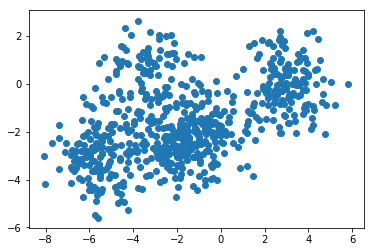

In [6]:
n=3#number of clusters
np.random.seed(37)
data = np.vstack(((np.random.randn(150, 2)  + np.array([3, 0])),
               (np.random.randn(100, 2)  + np.array([-3.5, 0.5])),
               (np.random.randn(100, 2) + np.array([-0.5, -2])),
               (np.random.randn(150, 2) + np.array([-2, -2.5])),
               (np.random.randn(150, 2) + np.array([-5.5, -3]))))

clusters = generate_clustering(data,"Spectral",n)
weights = generate_weights()
X = np.hstack([data,weights.reshape(-1,1),clusters.reshape(-1,1)])

plt.scatter(X[:,0],X[:,1])

train,test = train_test_split(X)
X_tr,Y_tr = train[:,:3],train[:,3]
X_t,Y_t = test[:,:3],test[:,3]

In [7]:
X[:5]

array([[ 2.94553639,  0.67430807, 72.124     ,  2.        ],
       [ 3.34664703, -1.30034617, 80.348     ,  2.        ],
       [ 4.51851188,  0.98982371, 73.926     ,  2.        ],
       [ 3.2776809 , -0.44858935, 70.322     ,  2.        ],
       [ 3.96196624, -0.82757864, 82.529     ,  2.        ]])

C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


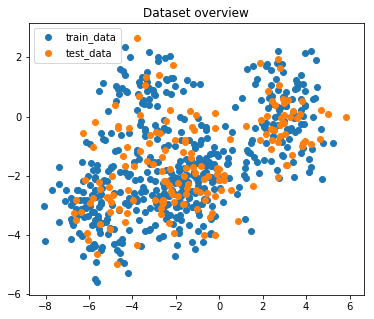

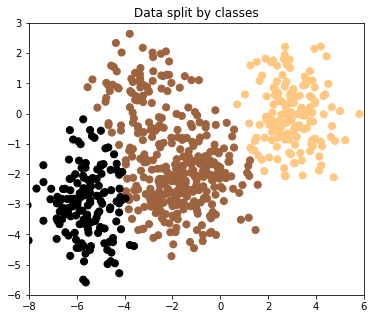

In [8]:
a1 = plt.figure(figsize=(6,5))

plt.scatter(X_tr[:,0],X_tr[:,1],label='train_data')
plt.scatter(X_t[:,0],X_t[:,1],label='test_data')

plt.title("Dataset overview")
plt.legend()
a1.show()
visualize_classes(train,test,Y_t.astype(int),demo=True,figsize=(6,5))

### Naive approach - KNN for regression

In [9]:
class KNN_regression(object):
    """
    KNN for regression
    
    Arguments:
    ---------
    k -- number of nearest neighbours
    X -- input matrix
    """
    def euclidean_dist(self,x,y):
        """
        Euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return (((y-x)**2)**0.5)
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    def manhattan_dist(self,x,y):
        """
        Manhattan distance between points x and y
        """
        if type(x)==np.float64:
            return (abs(x-y))
        return sum(abs(x[i]-y[i]) for i in range(len(x)))
        
    def split_data(self):
        train,test = train_test_split(self.X)
        self.X_train,self.X_test = train[:,0],test[:,0]
        self.Y_train,self.Y_test = test[:,1],test[:,1]

    
    def __init__(self,k=None,X = None, X_train=None, X_test = None, Y_train = None, Y_test = None, window_width = None):
        if X is None:
            self.X_train, self.X_test  = X_train, X_test
            self.Y_train, self.Y_test  = Y_train, Y_test
        else:
            self.X = X
            self.split_data()
        
        if k is not None:
            self.k = k
            self.parzen = False
        else:#using Parzen window  
            self.w = window_width
            self.parzen = True
      
    def predict_average(self, distances):
        return np.mean(distances)
    
    def predict_weighted_average(self,neighbours,weights):
        """
        Arguments:
        ---------
        neighbours -- list of k closest neighbours [[distance,index],...]
        weights -- list of inversed weights
        Returns:
        --------
        A float predicting property based on 
        """
        indices = [row[1] for row in neighbours]
        values = self.X_train[indices][:,2]
        
        return np.dot(values,weights)
        
    def get_Neighbours(self,point):
        """
        Arguments:
        ---------
        point -- chosen point from X_test
        
        Returns:
        ------
        list of k closest neighbours [[distance,index],...]
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        if self.parzen:
            i = sum(1 if d<=self.w else 0 for d in list(distances.values()))
            return list(distances.items())[:i]
        else:
            k_nearest = list(distances.items())[:self.k]
            return k_nearest
        #return [row[0] for row in k_nearest]
        
    def get_Neighbours_Parzen(self,point):
        """
        Arguments:
        ----------
        point -- chosen point from X_test
        Returns:
        list of points inside a Parzen window
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        
        i = sum(1 if d<=self.w else 0 for d in list(distances.values()))
        return list(distances.items())[:i]

    def get_Weights(self,neighbours):
        """
        Arguments:
        ---------
        neighbours -- list of k closest neighbours [[distance,index],...]
        Returns:
        ---------
        list of inversed weights - highest score for the closest point
        """
        distances = [row[0] for row in neighbours]
        inversed_distances = [sum(distances)/(d+1) for d in distances]
        return [d/sum(inversed_distances) for d in inversed_distances]
    
    def predict(self):
        prediction = []
        for point in self.X_test:
            #get neighbours
            neighbours = self.get_Neighbours(point)
            #calculate weight based on proximity of each point
            weights = self.get_Weights(neighbours)
            #predict price based on their values
            prediction.append(self.predict_weighted_average(neighbours,weights))
        self.pred = np.array(prediction)
        return self.pred
    
    def calculate_accuracy(self):
        return mean_squared_error(self.X_test[:,2],self.pred)
    
    def set_width(self, w):
        self.w = w
    
    def set_k(self,k):
        self.k = k

In [10]:
#nbrs = model.get_Neighbours(X_t[15])
#whts = model.get_Weights(nbrs)
#indices = [row[1] for row in nbrs]
#m = X_tr[indices][:,2]
#np.dot(m,whts)


model = KNN_regression(40,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
pr = model.predict()

model.calculate_accuracy()

0.9894402363177246

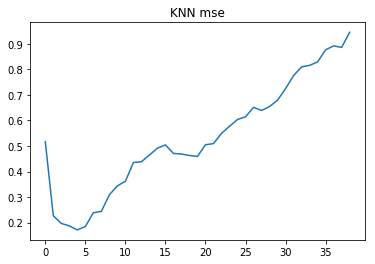

In [11]:
accuracy = []
model = KNN_regression(1,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
for i in range(1,40):
    model.set_k(i)
    pr = model.predict()
    accuracy.append(model.calculate_accuracy())
plt.title("KNN mse")

plt.plot(accuracy)

In [11]:
model = KNN_regression(X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test = Y_t, window_width=36.0)
pr = model.predict()

model.calculate_accuracy()

0.89152440337395

In [ ]:
m = 20.0 # max width
accuracy = []
model = KNN_regression(X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test = Y_t, window_width=1.0)
for i in np.arange(0.25,m,0.25):
    model.set_width(i)
    model.predict()
    accuracy.append(model.calculate_accuracy())
plt.title("Parzen window mse")
#plt.xticks(np.arange(0.25,m,step = 0.25))
plt.plot(accuracy)


### Metric gradient descent?

In [ ]:
def GD_fit(X,Y,l=0.0001,epochs = 1000):
    """
    Arguments:
    l -- learning rate
    epochs -- number of iterations
    X -- training set of X
    Y -- training set of Y
    Output:
    m,b -- params of Y = m*X+b - m is the slope, b is the intercept
    """
    n,m,b =len(X),0,0 #initial values
     
    for i in range(epochs):
        Y_pred = [m*x_i+b for x_i in X]
        D_m = (-2/n) * sum(x_i *(y_i-y_pred_i) for x_i,y_i,y_pred_i in zip(X,Y,Y_pred))
        D_b = (-2/n) * sum(y-y_i for y,y_i in zip(Y,Y_pred))
        m-=l*D_m
        b-=l*D_b
    return m,b


def GD_predict(x,m,b):
    return m*x + b


def test_GD(X_train,Y_train,X_test,Y_test):
    m,b = GD_fit(X_train,Y_train,0.001,1200)
    pred = np.array([GD_predict(i,m,b) for i in X_test])
    loss = mean_squared_error(Y_test,pred)
    print("loss = {0}".format(loss))
    visualize(X_train,Y_train,X_test,Y_test,Y_pred=pred)

In [ ]:
test_GD(X_tr,Y_tr,X_t,Y_t)

### [Nadaraya–Watson Kernel Regressor](https://en.wikipedia.org/wiki/Kernel_regression)

In [ ]:
class KernelRegressor:
    """
    Kernel Regressor
    """
    def __init__(self, X_tr,X_t,Y_tr,Y_t):
        #self.X_train,self.Y_train,self.X_test,self.Y_test = X_tr,Y_tr,X_t,Y_t
        self._samples, self._outputs = None, None
        
        
    def kernel(self):
        
        
    def fit(self,X,Y):
        
        
    def predict(self):
        
    def calculate_accuracy(self):
        

In [ ]:
def nwatson(x):
    a = sum(y_i*K(x,x_i) for x_i,y_i in zip(X_train,Y_train))
    b = sum(K(x,x_i) for x_i in X_train)
    return a/b